# Flipkart Laptop Review Topic Modeling

## Overview

This notebook analyze Flipkart laptop customer reviews and perform topic modeling to understand the underlying themes and sentiments in the reviews.

## Import libraries and set constants

In [1]:
# Core Libraries
import os
import random
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Libraries
import spacy
import emoji
from gensim import corpora
from gensim.models import Phrases, LdaModel, Nmf, CoherenceModel, TfidfModel
from gensim.models.phrases import Phraser
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer # For BERTopic

# Deep Learning (for Autoencoder)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Topic Modeling Framework
from bertopic import BERTopic

# Other
import kagglehub # For data download


RANDOM_STATE = 555
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Disable pydevd warning while training NMF and LDA
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
# Set environment variables for gensim and tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Set environment variables for spacy and random seed
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
# Improve reproducibility
os.environ['OMP_NUM_THREADS'] = '1'  # OpenMP
os.environ['MKL_NUM_THREADS'] = '1'  # MKL
os.environ['NUMEXPR_NUM_THREADS'] = '1'  # numexpr

# Data Collection and Preprocessing
- Download and explore the Flipkart laptop reviews dataset


In [2]:
# Download latest version
path = kagglehub.dataset_download("gitadityamaddali/flipkart-laptop-reviews")
df = pd.read_csv(os.path.join(path, "laptops_dataset_final_600.csv"))
# Initial exploration
print("Dataset Info:")
print("\nDataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())
print("\nCheck for missing values:")
print(df.isnull().sum())

Dataset Info:

Dataset Shape: (24113, 7)

First 5 Rows:
                                        product_name  overall_rating  \
0  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
1  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
2  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
3  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
4  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   

  no_ratings no_reviews  rating             title  \
0     15,210        900       5  Perfect product!   
1     15,210        900       5         Fabulous!   
2     15,210        900       5         Fabulous!   
3     15,210        900       4        Delightful   
4     15,210        900       5           Awesome   

                                              review  
0  Loved it, it's my first MacBook that I earned ...  
1  Battery lasted longer than my first relationsh...  
2  Such a great deal.. very

- Combine title and review into a single column named 'combined'
- Remove emojis from combined text
- Plot the distribution of combined text lengths

Total rows before length filtering: 24113


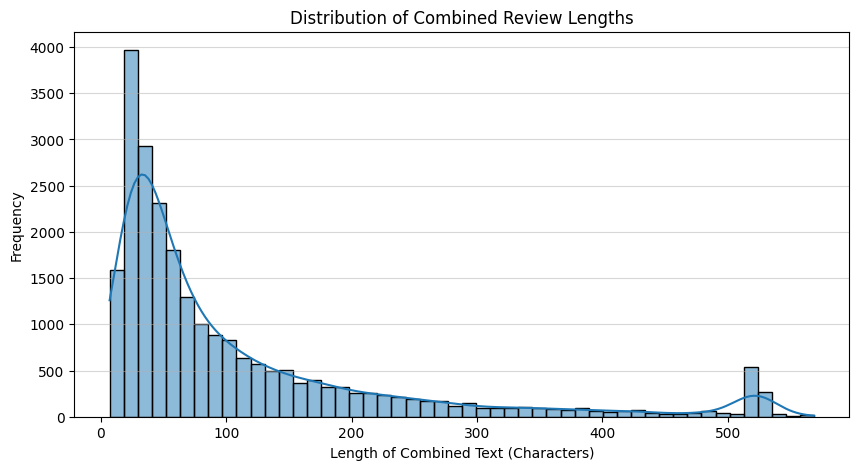

In [3]:
# Combine title and review
df['combined'] = df['title'] + ' ' + df['review']

# Remove emoji 
df['combined'] = df['combined'].apply(lambda text: emoji.replace_emoji(text, replace=''))

# Calculate length of combined text
df['combined_length'] = df['combined'].apply(len) 
print(f'Total rows before length filtering: {len(df)}')

plt.figure(figsize=(10, 5))
sns.histplot(df['combined_length'], bins=50, kde=True)
plt.title('Distribution of Combined Review Lengths')
plt.xlabel('Length of Combined Text (Characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()


- Clean and preprocess text data 
  - Tokenize text
  - Remove stopwords (while preserving negation words) - to preserve sentiment/context
  - Remove digits, space, punctuation, and special characters
  - Lemmatize tokens - to reduce words to root form

In [4]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Get the default stop words
default_stops = nlp.Defaults.stop_words

# Remove negation words from stop words
negation_words = {'no', 'not', 'nor', 'neither', 'never', "n't", "ain't", "aren't", 
                 "can't", "couldn't", "didn't", "doesn't", "don't", "hasn't", 
                 "haven't", "isn't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"}

# Comment out as it seems it is important to topic modeling
# domain_specific = {'laptop', 'product', 'battery', 'display', 'performance','quality','price'}

# Remove negation words from stop words
custom_stop_words = default_stops - negation_words
def preprocess_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.lemma_.lower() not in custom_stop_words and 
                                                    #    token.lemma_.lower() not in domain_specific and
                                                                            not token.is_stop and 
                                                                            not token.is_digit and
                                                                            not token.is_space and 
                                                                            not token.is_quote and
                                                                            not token.is_punct]
    return  tokens

df['combined_tokens'] = df['combined'].apply(preprocess_text)


- Filter out short reviews (under 5 tokens) - to remove context lacking document.

In [5]:
min_tokens = 5
rows_before_filter = len(df)
print(f"Rows before filtering short reviews: {rows_before_filter}")

# Filter out reviews with fewer than min_tokens after preprocessing
df = df[df['combined_tokens'].apply(len) >= min_tokens].copy() # Use .copy() to avoid SettingWithCopyWarning

rows_after_filter = len(df)
print(f"Rows after filtering (< {min_tokens} tokens): {rows_after_filter}")
print(f"Removed {rows_before_filter - rows_after_filter} short reviews.")

Rows before filtering short reviews: 24113
Rows after filtering (< 5 tokens): 15789
Removed 8324 short reviews.


## Feature Extraction and Feature Engineering


- Create n-grams (bigrams and trigrams) to capture multi-word phrases

In [6]:
min_count = max(5, int(len(df) * 0.001)) # At least 0.1% of the total documents but at least 5 occurrences
threshold = 10 # At least 10 occurrences 

print(f"Min count for n-grams: {min_count} and threshold: {threshold}")

# Create a list of tokenized documents
tokenized_docs = [doc for doc in df['combined_tokens']]

# Create bigram model
bigram = Phrases(tokenized_docs, min_count=min_count, threshold=threshold)  
bigram_mod = Phraser(bigram) 

# Create trigram model
trigram = Phrases(bigram_mod[tokenized_docs], min_count=min_count, threshold=threshold)  
trigram_mod = Phraser(trigram)

# Transform the documents with bigrams into documents with trigrams
docs_bigrams = [bigram_mod[doc] for doc in tokenized_docs]
docs_trigrams = [trigram_mod[bigram_mod[doc]] for doc in tokenized_docs]

# Create a dictionary and corpus
id2word = corpora.Dictionary(docs_trigrams)

corpus = [id2word.doc2bow(doc) for doc in docs_trigrams]
print(f"Number of unique tokens: {len(id2word)}")

Min count for n-grams: 15 and threshold: 10
Number of unique tokens: 7296


- Visualize most common bigrams and trigrams

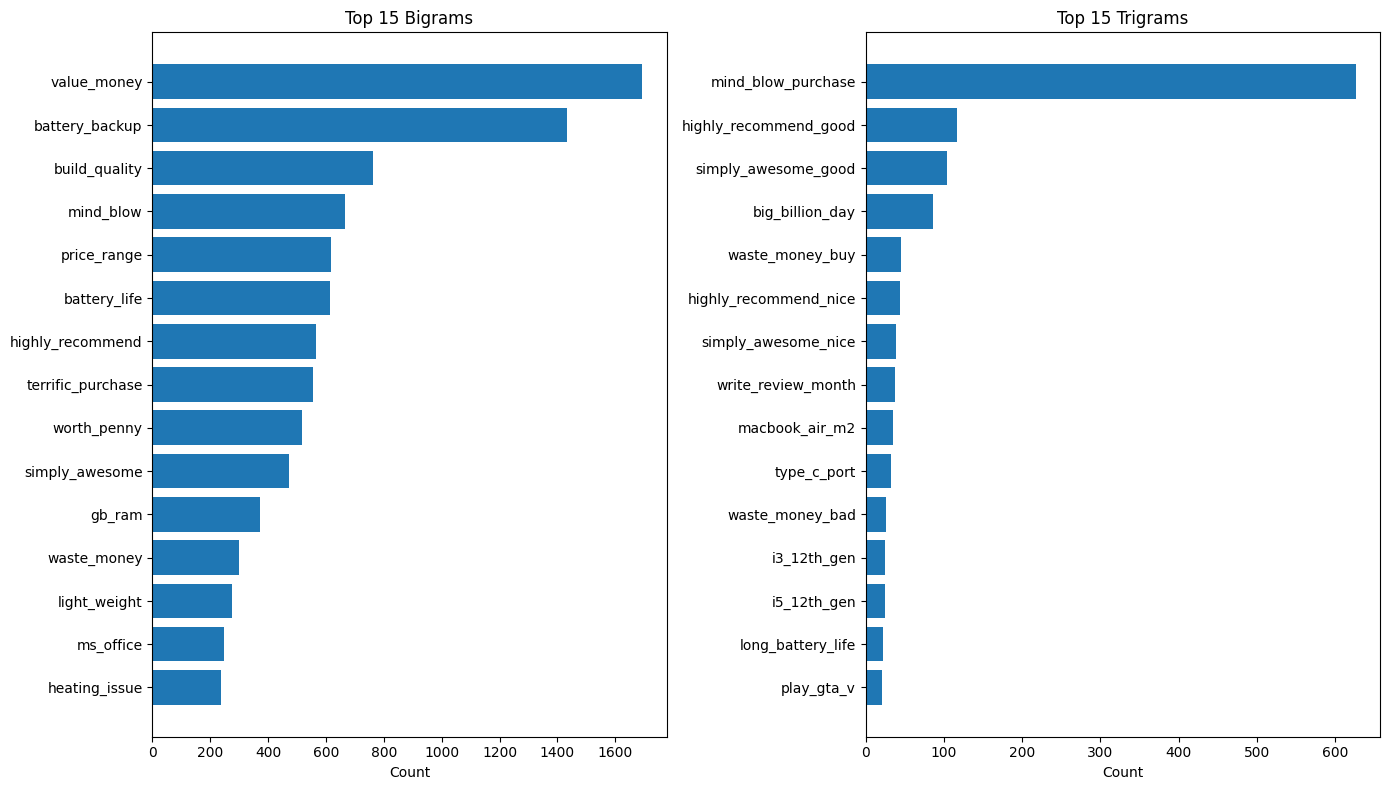

In [7]:
# Display the most common bigrams and trigrams
bigram_phrases = []
# Get the most common bigrams from the tokenized documents
bigram_counter = Counter()
for doc in docs_bigrams:
    for i in range(len(doc) - 1):
        if '_' in doc[i]:  # This is a bigram
            bigram_counter[doc[i]] += 1

# Get top 20 bigrams
top_bigrams = bigram_counter.most_common(20)

# Get most common trigrams from the tokenized documents
trigram_counter = Counter()
for doc in docs_trigrams:
    for token in doc:
        if token.count('_') == 2:  # This is a trigram
            trigram_counter[token] += 1

# Get top 20 trigrams
top_trigrams = trigram_counter.most_common(20)

# Visualize top bigrams and trigrams
# Plot bigrams
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
bigram_words, bigram_counts = zip(*top_bigrams[:15]) if top_bigrams else ([], [])
bigram_words = bigram_words[::-1]
bigram_counts = bigram_counts[::-1]
plt.barh(range(len(bigram_words)), bigram_counts, align='center')
plt.yticks(range(len(bigram_words)), bigram_words)
plt.title('Top 15 Bigrams')
plt.xlabel('Count')

# Plot trigrams
plt.subplot(1, 2, 2)
trigram_words, trigram_counts = zip(*top_trigrams[:15]) if top_trigrams else ([], [])
trigram_words = trigram_words[::-1]
trigram_counts = trigram_counts[::-1]
plt.barh(range(len(trigram_words)), trigram_counts, align='center')
plt.yticks(range(len(trigram_words)), trigram_words)
plt.title('Top 15 Trigrams')
plt.xlabel('Count')

plt.tight_layout()
plt.show()


## Model Training and Evaluation

### Topic Modeling: LDA and NMF


- Determine optimal number of topics using coherence scores
- Train LDA model on BoW representation as BoW is more suitable for LDA models.
- Train NMF model on TF-IDF representation as TF-IDF is more suitable for NMF models.

In [8]:
lda_passes, nmf_passes = 10, 10
lda_iterations = 400 # iterations is often within LdaModel, but passes is the main outer loop parameter

# --- Define Topic Range ---
topic_limit = 10
topic_start = 2
topic_step = 1


# Corpus Text
final_texts = docs_trigrams

# Corpus in BoW
corpus_bow = [id2word.doc2bow(text) for text in final_texts]

# Corpus in TF-IDF
tfidf = TfidfModel(corpus_bow, id2word=id2word)
corpus_tfidf = tfidf[corpus_bow]


def compute_coherence_values(dictionary, 
                             corpus, 
                             texts: list[str], 
                             limit: int, 
                             start:int=2, 
                             step:int=3, 
                             model_type='lda'):
    coherence_values = []
    model_list = []
    num_topics_range = range(start, limit, step)

    for num_topics in num_topics_range: 
        if model_type == 'lda':
            model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=RANDOM_STATE,
                             passes=lda_passes,
                             alpha='auto',
                             eta='auto',
                             per_word_topics=True,
                             chunksize=2000,
                             decay=0.5,
                             offset=1.0,
                             eval_every=1,
                             gamma_threshold=0.001) # Needed for some coherence/vis
        elif model_type == 'nmf':
             model = Nmf(corpus=corpus, # Use appropriate corpus (TFIDF often better)
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=RANDOM_STATE,
                         passes=nmf_passes,
                         eval_every=0) # Don't evaluate perplexity during training here 
        else:
            raise ValueError("model_type must be 'lda' or 'nmf'")

        model_list.append(model)

        # Use the model object directly if CoherenceModel supports it for NMF in your gensim version
        # Otherwise, you might need to extract topics manually for NMF as shown before
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Training {model_type.upper()} with {num_topics} topics... -> Coherence (c_v) for {num_topics} topics: {coherence_values[-1]:.4f}")


    return model_list, coherence_values, list(num_topics_range)


# --- Calculate Coherence for LDA ---
print("Calculating LDA Coherence...")
# Use BoW corpus for LDA training
lda_model_list, lda_coherence_values, lda_num_topics_range = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus_bow,
    texts=final_texts,
    start=topic_start,
    limit=topic_limit,
    step=topic_step,
    model_type='lda'
)

# --- Calculate Coherence for NMF ---
print("\nCalculating NMF Coherence...")
# Use TF-IDF corpus for NMF training (recommended)
nmf_model_list, nmf_coherence_values, nmf_num_topics_range = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus_tfidf, # Using TF-IDF here
    texts=final_texts,
    start=topic_start,
    limit=topic_limit,
    step=topic_step,
    model_type='nmf'
)


Calculating LDA Coherence...
Training LDA with 2 topics... -> Coherence (c_v) for 2 topics: 0.4989
Training LDA with 3 topics... -> Coherence (c_v) for 3 topics: 0.5203
Training LDA with 4 topics... -> Coherence (c_v) for 4 topics: 0.5152
Training LDA with 5 topics... -> Coherence (c_v) for 5 topics: 0.5035
Training LDA with 6 topics... -> Coherence (c_v) for 6 topics: 0.5266
Training LDA with 7 topics... -> Coherence (c_v) for 7 topics: 0.4916
Training LDA with 8 topics... -> Coherence (c_v) for 8 topics: 0.4623
Training LDA with 9 topics... -> Coherence (c_v) for 9 topics: 0.5094

Calculating NMF Coherence...
Training NMF with 2 topics... -> Coherence (c_v) for 2 topics: 0.3636
Training NMF with 3 topics... -> Coherence (c_v) for 3 topics: 0.3564
Training NMF with 4 topics... -> Coherence (c_v) for 4 topics: 0.3653
Training NMF with 5 topics... -> Coherence (c_v) for 5 topics: 0.3779
Training NMF with 6 topics... -> Coherence (c_v) for 6 topics: 0.3730
Training NMF with 7 topics... -


Plotting coherence scores...


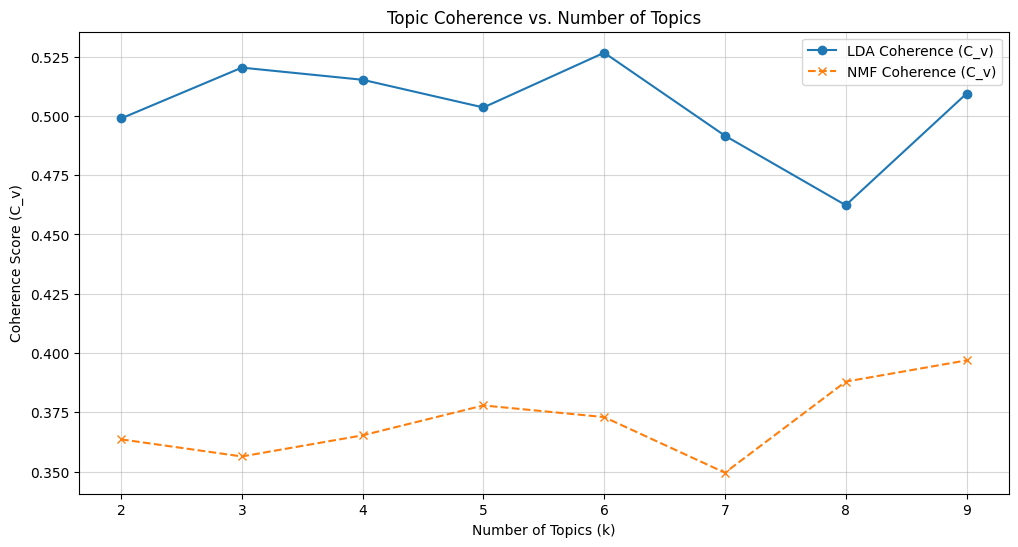


Optimal number of topics for LDA (based on max C_v): 6 (Coherence: 0.5266)
Optimal number of topics for NMF (based on max C_v): 9 (Coherence: 0.3969)

Selected best LDA and NMF models based on highest C_v score.


In [9]:
# --- Plotting Coherence Scores ---
print("\nPlotting coherence scores...")
plt.figure(figsize=(12, 6))
plt.plot(lda_num_topics_range, lda_coherence_values, marker='o', linestyle='-', label='LDA Coherence (C_v)')
plt.plot(nmf_num_topics_range, nmf_coherence_values, marker='x', linestyle='--', label='NMF Coherence (C_v)')
plt.title('Topic Coherence vs. Number of Topics')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Coherence Score (C_v)")
plt.xticks(np.arange(topic_start, topic_limit, topic_step))
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# --- Select Optimal K and Best Models ---
# Note: Optimal K is often a balance between high coherence and interpretability.
# Sometimes an 'elbow' point before the peak is better if the peak represents overly granular topics.
optimal_k_lda_idx = np.argmax(lda_coherence_values)
optimal_k_nmf_idx = np.argmax(nmf_coherence_values)

optimal_k_lda = lda_num_topics_range[optimal_k_lda_idx]
optimal_k_nmf = nmf_num_topics_range[optimal_k_nmf_idx]

print(f"\nOptimal number of topics for LDA (based on max C_v): {optimal_k_lda} (Coherence: {lda_coherence_values[optimal_k_lda_idx]:.4f})")
print(f"Optimal number of topics for NMF (based on max C_v): {optimal_k_nmf} (Coherence: {nmf_coherence_values[optimal_k_nmf_idx]:.4f})")

# !! Important: Manually inspect the plot. Choose K based on peak/elbow AND interpretability later.
# For now, we proceed with the highest coherence score K.
best_lda_model = lda_model_list[optimal_k_lda_idx]
best_nmf_model = nmf_model_list[optimal_k_nmf_idx]

print("\nSelected best LDA and NMF models based on highest C_v score.")

- Compare and visualize topics and word distribution

In [10]:
print("LDA Topics:")
for topic in best_lda_model.print_topics(num_words=10):
    print(topic)
    
    
print("\nNMF Topics:")
for topic in best_nmf_model.print_topics(num_words=10):
    print(topic)


LDA Topics:
(0, '0.022*"laptop" + 0.016*"display" + 0.012*"read" + 0.011*"great" + 0.011*"processor" + 0.011*"gb_ram" + 0.010*"con" + 0.010*"gaming" + 0.010*"gb" + 0.009*"game"')
(1, '0.050*"mind_blow_purchase" + 0.035*"worth_penny" + 0.013*"issue" + 0.013*"warranty" + 0.011*"laptop" + 0.010*"range" + 0.010*"hp" + 0.009*"year" + 0.009*"beast" + 0.008*"product"')
(2, '0.081*"great" + 0.033*"product" + 0.031*"flipkart" + 0.019*"delivery" + 0.014*"laptop" + 0.012*"superb" + 0.012*"thank" + 0.009*"look" + 0.009*"asus" + 0.007*"service"')
(3, '0.013*"game" + 0.013*"read" + 0.013*"laptop" + 0.013*"run" + 0.013*"work" + 0.012*"like" + 0.012*"day" + 0.011*"use" + 0.011*"gaming" + 0.011*"heavy"')
(4, '0.055*"bad" + 0.032*"poor" + 0.029*"buy" + 0.026*"laptop" + 0.022*"issue" + 0.017*"problem" + 0.016*"work" + 0.016*"waste_money" + 0.014*"day" + 0.013*"product"')
(5, '0.135*"good" + 0.072*"laptop" + 0.071*"product" + 0.037*"performance" + 0.027*"display" + 0.026*"nice" + 0.024*"battery" + 0.022*"

- Plot word clouds

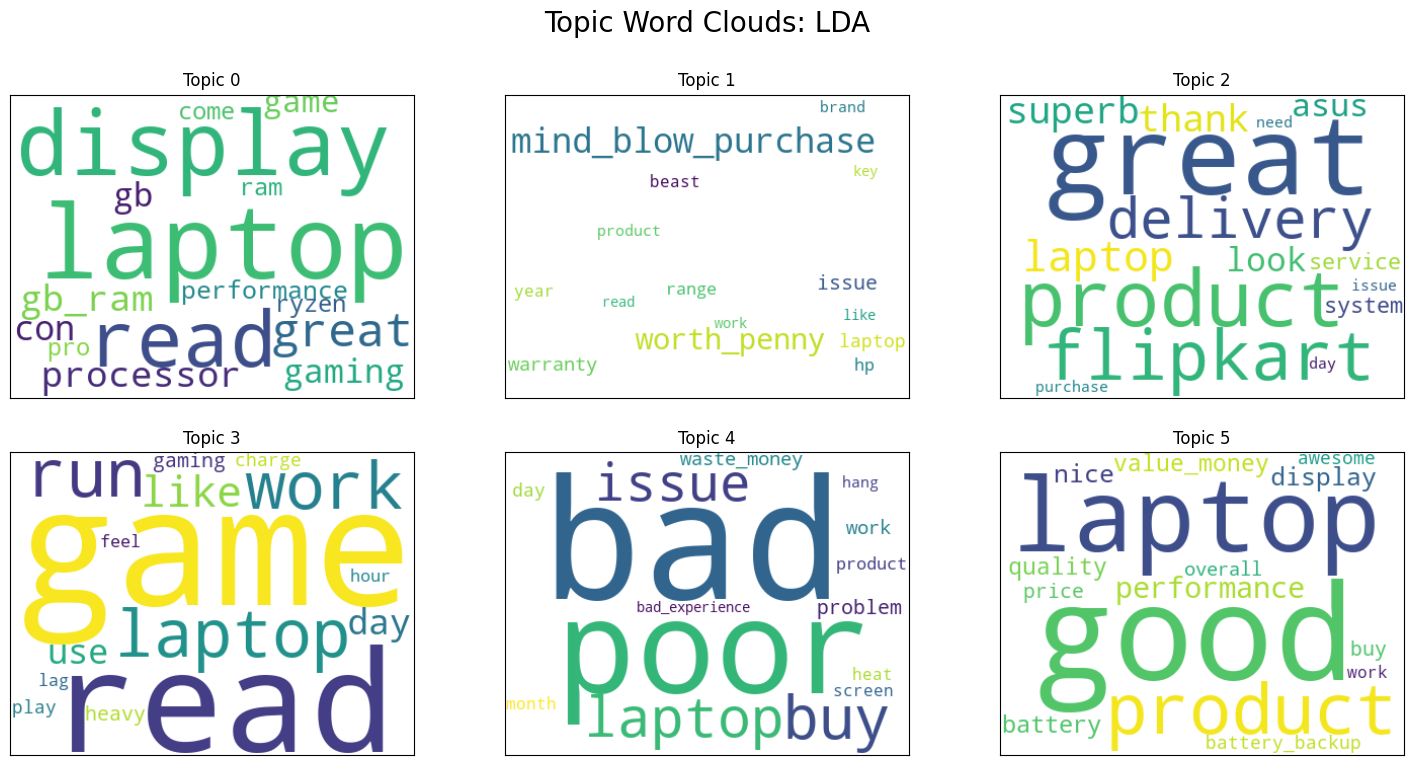

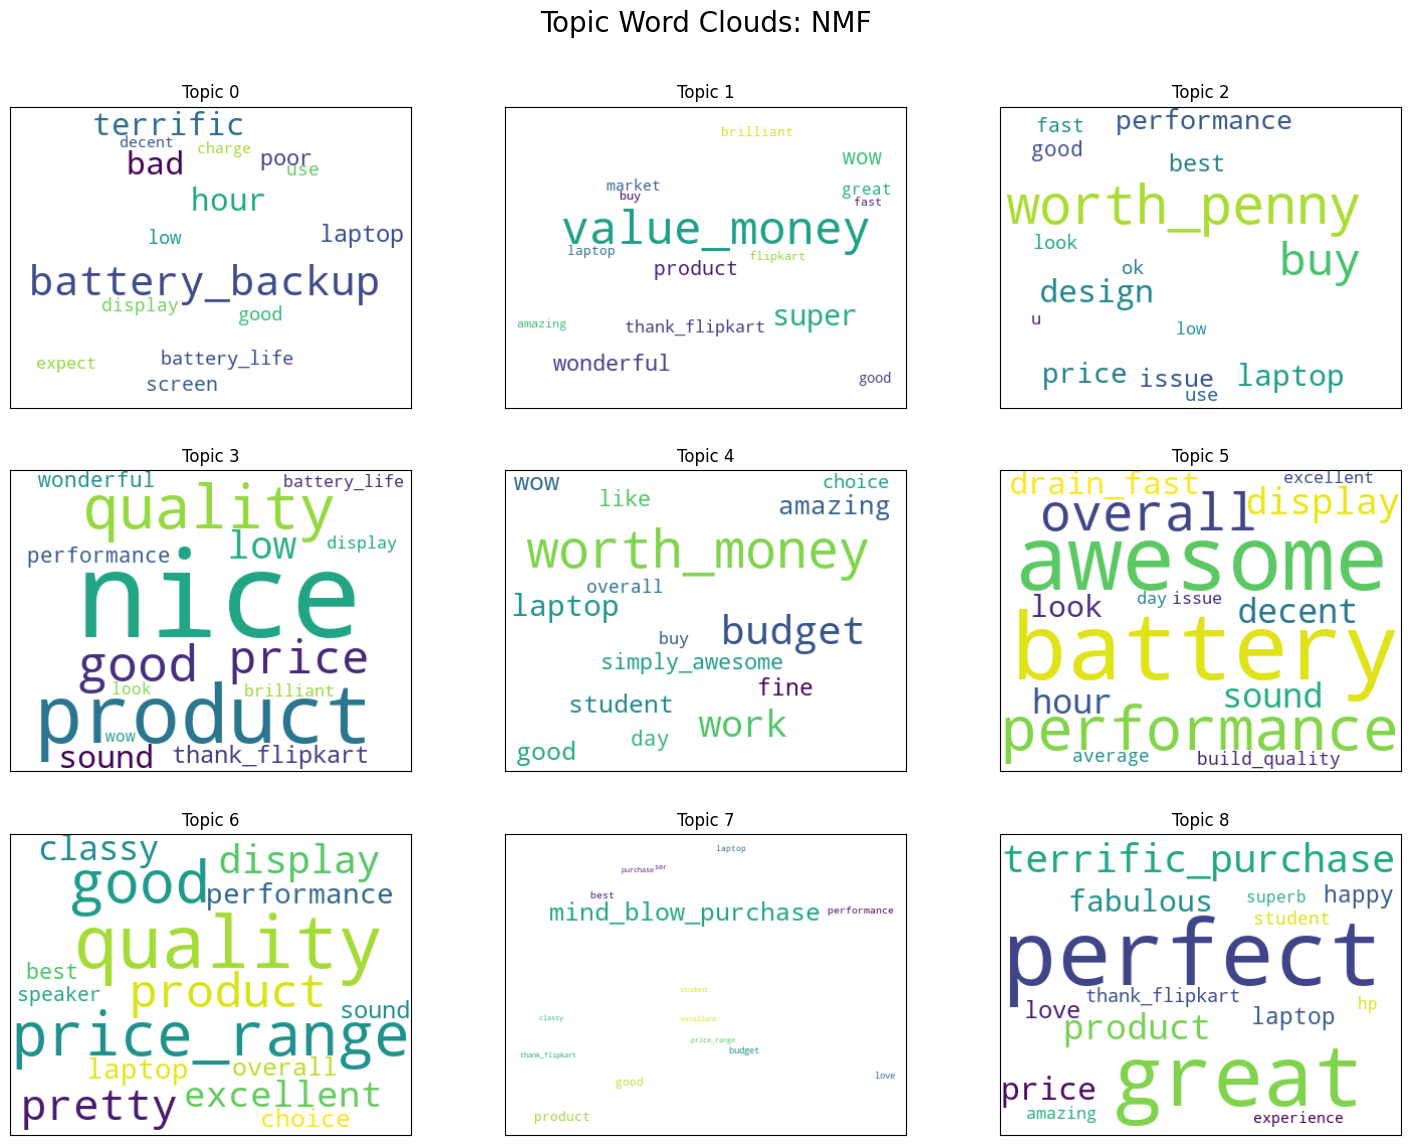

In [11]:
# Function to create word clouds for topics
def create_topic_wordclouds(topics_dict, model_name, ncols=3): 
    # Calculate grid dimensions
    n_topics = len(topics_dict)
    nrows = (n_topics + ncols - 1) // ncols
    
    # Create figure
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                             figsize=(5*ncols, 4*nrows),
                             subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle(f'Topic Word Clouds: {model_name}', fontsize=20)
    
    # Flatten axes for easier iteration if we have multiple rows
    if nrows > 1:
        axes = axes.flatten()
    
    # Create wordcloud for each topic
    for i, (topic_id, topic_words) in enumerate(topics_dict.items()):
        if isinstance(topic_words[0], tuple):  # If words have weights (word, weight)
            word_weights = {word: weight for word, weight in topic_words}
        else:  # If just list of words
            word_weights = {word: 1 for word in topic_words}
        
        # Create and plot wordcloud
        wordcloud = WordCloud(width=400, height=300, 
                              background_color='white',
                              colormap='viridis',
                              prefer_horizontal=1.0,
                              max_words=100).generate_from_frequencies(word_weights)
        
        # Place in appropriate subplot
        if nrows == 1 and ncols == 1:
            axes.imshow(wordcloud, interpolation='bilinear')
            axes.set_title(f'Topic {topic_id}')
        elif nrows == 1:
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'Topic {topic_id}')
        else:
            if i < len(axes):  # Check if we have enough axes
                axes[i].imshow(wordcloud, interpolation='bilinear')
                axes[i].set_title(f'Topic {topic_id}')
    
    # Hide unused subplots
    if nrows > 1 or ncols > 1:
        for j in range(i + 1, nrows * ncols):
            if j < len(axes):
                axes[j].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96], h_pad=4.0) # Adjust for suptitle
    plt.show()
    
# Create dictionary of LDA topics for word cloud visualization
lda_topics = {}
for topic_id, topic in enumerate(best_lda_model.get_topics()):
    # Get the word IDs sorted by weight
    sorted_word_ids = sorted(range(len(topic)), key=lambda i: -topic[i])[:15]
    # Convert word IDs to words with weights
    topic_words = [(id2word[word_id], topic[word_id]) for word_id in sorted_word_ids if topic[word_id] > 0]
    lda_topics[topic_id] = topic_words

# Create word clouds for LDA topics
create_topic_wordclouds(lda_topics, "LDA")

nmf_topics = {}
for topic_id, topic in enumerate(best_nmf_model.get_topics()):
    # Get the word IDs sorted by weight
    sorted_word_ids = sorted(range(len(topic)), key=lambda i: -topic[i])[:15]
    # Convert word IDs to words with weights
    topic_words = [(id2word[word_id], topic[word_id]) for word_id in sorted_word_ids if topic[word_id] > 0]
    nmf_topics[topic_id] = topic_words

# Create word clouds for NMF topics
create_topic_wordclouds(nmf_topics, "NMF")

## Model Refinement and Optimization (Alternative Topic Modeling Approaches)
- Experiment with different autoencoder architectures, hyperparameters, and reconstruction error thresholds to fine-tune the model's performance.
- Apply techniques such as learning rate scheduling, regularization, and dropout to improve the model's generalization and robustness.


#### 1. Autoencoder topic modeling
- Autoencoder can used in topic modeling by compressing the each data point into a lower-dimensional representation captureing weight in the bottleneck layer.

In [12]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=5, binary=True)
final_documents = [' '.join(doc) for doc in final_texts]

bow = vectorizer.fit_transform(final_documents) 
bow_dense = bow.toarray()

- Autoencoder architecture

In [13]:
# # Set parameters
# input_dim = bow_dense.shape[1]  # Vocabulary size
# encoding_dim = 5       # Number of topics

# # Input layer
# input_layer = Input(shape=(input_dim,))

# # Encoder
# encoded = Dense(128, activation='relu')(input_layer)
# encoded = Dropout(0.2)(encoded)
# encoded = Dense(64, activation='relu')(encoded)
# encoded = Dropout(0.2)(encoded)

# # Bottleneck layer (topics)
# bottleneck = Dense(encoding_dim, activation='relu', 
#                   activity_regularizer=regularizers.l1(10e-5))(encoded)

# # Decoder
# decoded = Dense(64, activation='relu')(bottleneck)
# decoded = Dropout(0.2)(decoded)
# decoded = Dense(128, activation='relu')(decoded)
# decoded = Dropout(0.2)(decoded)

# # Output layer
# output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# # Full autoencoder
# autoencoder = Model(inputs=input_layer, outputs=output_layer)

# # Encoder model for extracting topics
# encoder = Model(inputs=input_layer, outputs=bottleneck)
# # Use a smaller learning rate
# optimizer = Adam(learning_rate=0.00001)  # Default is 0.001
# # Compile the model
# autoencoder.compile(
#     optimizer=optimizer,
#     loss='binary_crossentropy',  # or BinaryCrossentropy()
# )

# autoencoder.summary()


- Train the autoencoder model

In [14]:
# ae_history = autoencoder.fit(
#     bow_dense, bow_dense,  # Input and target are the same for autoencoders
#     epochs=100,
#     batch_size=256,
#     shuffle=True,
#     validation_split=0.2,
#     verbose=1,
# )

# # Plot training history
# plt.figure(figsize=(10, 4)) 
# plt.plot(ae_history.history['loss'], label='Training Loss')
# plt.plot(ae_history.history['val_loss'], label='Validation Loss')
# plt.title('Autoencoder Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()


In [15]:
# # After training is complete, extract the document-topic representation
# document_topics = encoder.predict(bow_dense)

# # Get the decoder weights to identify words associated with each topic
# decoder_layer = autoencoder.layers[-1]  # Get the output layer
# decoder_weights = decoder_layer.get_weights()[0]  # Get weights connecting to output

# # Get your vocabulary
# vocabulary = vectorizer.get_feature_names_out()

# # For each topic, find the top words
# n_top_words = 10
# for topic_idx in range(encoding_dim):
#     # Get topic weights
#     topic = decoder_weights[topic_idx]
#     # Get top word indices for this topic
#     top_word_indices = topic.argsort()[-n_top_words:][::-1]
#     # Get the actual words
#     top_words = [vocabulary[i] for i in top_word_indices]
#     # Print topic and its top words
#     print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

In [16]:
# # Create dictionary of Autoencoder topics for word cloud visualization
# autoencoder_topics = {}
# for topic_idx in range(encoding_dim):
#     # Get topic weights from decoder weights
#     topic = decoder_weights[topic_idx]
    
#     # Get top word indices and weights
#     top_indices = topic.argsort()[-20:][::-1]  # Get top 20 words
    
#     # Create list of (word, weight) tuples
#     topic_words = [(vocabulary[i], float(topic[i])) for i in top_indices if topic[i] > 0]
#     autoencoder_topics[topic_idx] = topic_words

# # Create word clouds for Autoencoder topics
# create_topic_wordclouds(autoencoder_topics, "Autoencoder")

#### 2. BERTopic model

- use embedding model from sentence-transformers "all-mpnet-base-v2" as its has the best average performance.

In [17]:
# # Optional but recommended: Choose a specific sentence transformer model
# # You can find models here: https://www.sbert.net/docs/pretrained_models.html
# # 'all-MiniLM-L6-v2' is a good default - fast and good quality.
# # embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# embedding_model = SentenceTransformer("all-mpnet-base-v2")

# # Initialize BERTopic
# # nr_topics='auto' lets HDBSCAN find the optimal number.
# # Or set nr_topics=num_topics (same as LDA/NMF) for a more direct comparison,
# # but 'auto' is often better for BERTopic's quality.
# # min_topic_size controls the minimum size of cluster to be considered a topic
# bertopic_model = BERTopic(
#     embedding_model=embedding_model, # Use the chosen embedding model
#     language="english",              # Set language (if multilingual, use "multilingual")
#     # nr_topics="auto",              # Let BERTopic determine the number of topics
#     nr_topics=9,                # OR Force the same number of topics as LDA/NMF
#     min_topic_size=10,               # Minimum number of documents for a cluster to be topic 
# )

# # Fit the model on your raw documents
# topics, probabilities = bertopic_model.fit_transform([' '.join(doc) for doc in docs_trigrams])

# # --- Accessing BERTopic Results ---
# print("BERTopic Model Info:")
# print(bertopic_model.get_topic_info()) # DataFrame with topic info (size, name, top words)

# print("\nTop words per BERTopic topic:")
# # Get the top N words for each topic (excluding the outlier topic -1 if it exists)
# num_top_words = 10
# bertopic_topics = {}
# for topic_id in sorted(bertopic_model.get_topics().keys()):
#     if topic_id == -1: continue # Skip outlier topic
#     topic_words = [word for word, score in bertopic_model.get_topic(topic_id)][:num_top_words]
#     bertopic_topics[topic_id] = topic_words
#     print(f"Topic {topic_id}: {', '.join(topic_words)}")

In [18]:
# # Create dictionary of BERTopic topics for word cloud visualization
# bertopic_topics_wc = {}
# for topic_id in sorted(bertopic_model.get_topics().keys()):
#     if topic_id == -1: continue  # Skip outlier topic
#     # BERTopic already provides (word, weight) format
#     topic_words = bertopic_model.get_topic(topic_id)[:20]  # Get top 20 words
#     bertopic_topics_wc[topic_id] = topic_words

# # Create word clouds for BERTopic topics
# create_topic_wordclouds(bertopic_topics_wc, "BERTopic")

In [21]:
def calculate_bertopic_coherence(embedding_model, texts, dictionary, limit=10, start=2, step=1):
    coherence_values = []
    model_list = []
    num_topics_range = range(start, limit, step)
    
    # Store the original documents to reset later
    original_docs = [' '.join(doc) for doc in texts]
    
    print("Calculating BERTopic Coherence...")
    
    for num_topics in num_topics_range:
        # Create a new BERTopic model with specified number of topics
        model = BERTopic(
            embedding_model=embedding_model,
            language="english",
            nr_topics=num_topics,
            min_topic_size=10,
        )
        
        # Fit the model
        topics, _ = model.fit_transform(original_docs)
        
        # Store the model
        model_list.append(model)
        
        # For coherence calculation, we need topic-word lists in gensim format
        topic_words = []
        for topic_idx in sorted(model.get_topics().keys()):
            if topic_idx == -1:  # Skip outlier topic
                continue
            # Get top N words for topic
            words = [word for word, _ in model.get_topic(topic_idx)][:10]  # Top 10 words
            topic_words.append(words)
        
        # Calculate coherence using CoherenceModel
        coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
        
        print(f"Training BERTopic with {num_topics} topics... -> Coherence (c_v) for {num_topics} topics: {coherence_score:.4f}")
    
    return model_list, coherence_values, list(num_topics_range)


# === Coherence Score for Autoencoder ===

def calculate_autoencoder_coherence(input_dim, texts, dictionary, vectorizer, limit=10, start=2, step=1):
    coherence_values = []
    model_list = []
    num_topics_range = range(start, limit, step)
    
    # Get BOW representation
    final_documents = [' '.join(doc) for doc in texts]
    bow = vectorizer.transform(final_documents)
    bow_dense = bow.toarray()
    
    vocabulary = vectorizer.get_feature_names_out()
    
    print("Calculating Autoencoder Coherence...")
    
    for encoding_dim in num_topics_range:
        # Input layer
        input_layer = Input(shape=(input_dim,))
        
        # Encoder
        encoded = Dense(128, activation='relu')(input_layer)
        encoded = Dropout(0.2)(encoded)
        encoded = Dense(64, activation='relu')(encoded)
        encoded = Dropout(0.2)(encoded)
        
        # Bottleneck layer (topics)
        bottleneck = Dense(encoding_dim, activation='relu', 
                          activity_regularizer=regularizers.l1(10e-5))(encoded)
        
        # Decoder
        decoded = Dense(64, activation='relu')(bottleneck)
        decoded = Dropout(0.2)(decoded)
        decoded = Dense(128, activation='relu')(decoded)
        decoded = Dropout(0.2)(decoded)
        
        # Output layer
        output_layer = Dense(input_dim, activation='sigmoid')(decoded)
        
        # Full autoencoder
        autoencoder = Model(inputs=input_layer, outputs=output_layer)
        
        # Encoder model for extracting topics
        encoder = Model(inputs=input_layer, outputs=bottleneck)
        
        # Compile the model
        optimizer = Adam(learning_rate=0.00001)
        autoencoder.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
        )
        
        # Train model (using fewer epochs for faster testing)
        ae_history = autoencoder.fit(
            bow_dense, bow_dense,
            epochs=30,  # Reduced from 100 for speed
            batch_size=256,
            shuffle=True,
            validation_split=0.2,
            verbose=0,  # Silence the output for cleaner coherence scores
        )
        
        # Get decoder weights
        decoder_layer = autoencoder.layers[-1]
        decoder_weights = decoder_layer.get_weights()[0]
        
        # Convert to format for coherence calculation
        topic_words = []
        for topic_idx in range(encoding_dim):
            # Get topic weights
            topic = decoder_weights[topic_idx]
            # Get top word indices for this topic
            top_word_indices = topic.argsort()[-10:][::-1]  # Top 10 words
            # Get the actual words
            top_words = [vocabulary[i] for i in top_word_indices]
            topic_words.append(top_words)
        
        # Calculate coherence using CoherenceModel
        coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
        
        # Store the model for reference
        model_list.append((autoencoder, encoder, decoder_weights))
        
        print(f"Training Autoencoder with {encoding_dim} topics... -> Coherence (c_v) for {encoding_dim} topics: {coherence_score:.4f}")
    
    return model_list, coherence_values, list(num_topics_range)

In [22]:
# For BERTopic
embedding_model = SentenceTransformer("all-mpnet-base-v2")
bertopic_model_list, bertopic_coherence_values, bertopic_num_topics_range = calculate_bertopic_coherence(
    embedding_model, 
    final_texts,
    id2word,
    limit=topic_limit,
    start=topic_start,
    step=topic_step
)

# For Autoencoder
autoencoder_model_list, autoencoder_coherence_values, autoencoder_num_topics_range = calculate_autoencoder_coherence(
    input_dim=bow_dense.shape[1],
    texts=final_texts,
    dictionary=id2word,
    vectorizer=vectorizer,
    limit=topic_limit,
    start=topic_start,
    step=topic_step
)

Calculating BERTopic Coherence...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Training BERTopic with 2 topics... -> Coherence (c_v) for 2 topics: 0.3973
Training BERTopic with 3 topics... -> Coherence (c_v) for 3 topics: 0.4071
Training BERTopic with 4 topics... -> Coherence (c_v) for 4 topics: 0.3432
Training BERTopic with 5 topics... -> Coherence (c_v) for 5 topics: 0.3435
Training BERTopic with 6 topics... -> Coherence (c_v) for 6 topics: 0.3550
Training BERTopic with 7 topics... -> Coherence (c_v) for 7 topics: 0.3883
Training BERTopic with 8 topics... -> Coherence (c_v) for 8 topics: 0.4071
Training BERTopic with 9 topics... -> Coherence (c_v) for 9 topics: 0.4202
Calculating Autoencoder Coherence...


2025-04-12 23:54:22.188941: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-12 23:54:22.189139: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-12 23:54:22.189143: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1744516462.189717 2845886 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744516462.189772 2845886 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04-12 23:54:22.822098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training Autoencoder with 2 topics... -> Coherence (c_v) for 2 topics: 0.5264
Training Autoencoder with 3 topics... -> Coherence (c_v) for 3 topics: 0.4354
Training Autoencoder with 4 topics... -> Coherence (c_v) for 4 topics: 0.5445
Training Autoencoder with 5 topics... -> Coherence (c_v) for 5 topics: 0.5154
Training Autoencoder with 6 topics... -> Coherence (c_v) for 6 topics: 0.4600
Training Autoencoder with 7 topics... -> Coherence (c_v) for 7 topics: 0.5011
Training Autoencoder with 8 topics... -> Coherence (c_v) for 8 topics: 0.4697
Training Autoencoder with 9 topics... -> Coherence (c_v) for 9 topics: 0.5281


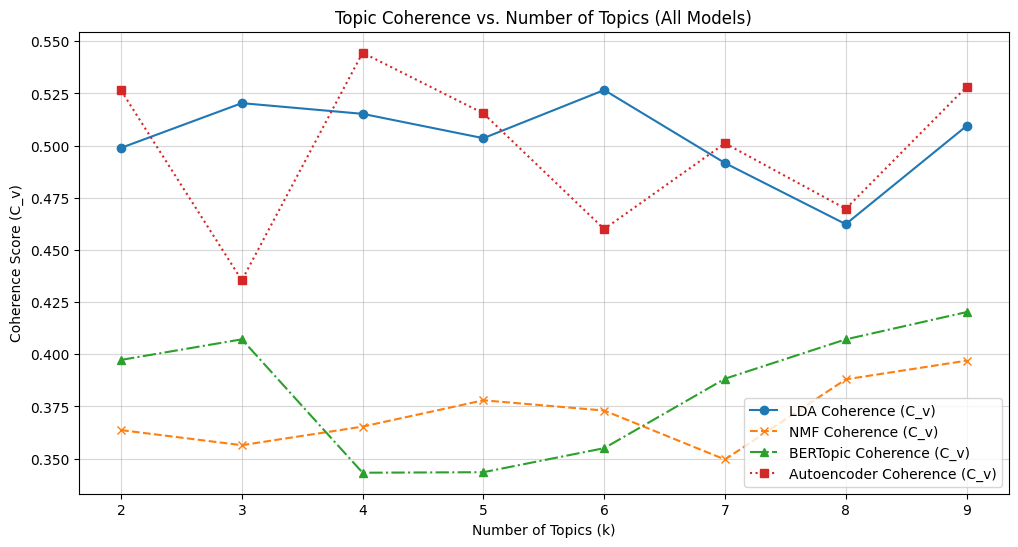


Optimal number of topics for BERTopic (based on max C_v): 9 (Coherence: 0.4202)
Optimal number of topics for Autoencoder (based on max C_v): 4 (Coherence: 0.5445)


In [23]:
plt.figure(figsize=(12, 6))
plt.plot(lda_num_topics_range, lda_coherence_values, marker='o', linestyle='-', label='LDA Coherence (C_v)')
plt.plot(nmf_num_topics_range, nmf_coherence_values, marker='x', linestyle='--', label='NMF Coherence (C_v)')
plt.plot(bertopic_num_topics_range, bertopic_coherence_values, marker='^', linestyle='-.', label='BERTopic Coherence (C_v)')
plt.plot(autoencoder_num_topics_range, autoencoder_coherence_values, marker='s', linestyle=':', label='Autoencoder Coherence (C_v)')
plt.title('Topic Coherence vs. Number of Topics (All Models)')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Coherence Score (C_v)")
plt.xticks(np.arange(topic_start, topic_limit, topic_step))
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# Find optimal topic numbers for all models
optimal_k_bertopic_idx = np.argmax(bertopic_coherence_values)
optimal_k_autoencoder_idx = np.argmax(autoencoder_coherence_values)

optimal_k_bertopic = bertopic_num_topics_range[optimal_k_bertopic_idx]
optimal_k_autoencoder = autoencoder_num_topics_range[optimal_k_autoencoder_idx]

print(f"\nOptimal number of topics for BERTopic (based on max C_v): {optimal_k_bertopic} (Coherence: {bertopic_coherence_values[optimal_k_bertopic_idx]:.4f})")
print(f"Optimal number of topics for Autoencoder (based on max C_v): {optimal_k_autoencoder} (Coherence: {autoencoder_coherence_values[optimal_k_autoencoder_idx]:.4f})")

# Get best models
best_bertopic_model = bertopic_model_list[optimal_k_bertopic_idx]
best_autoencoder_tuple = autoencoder_model_list[optimal_k_autoencoder_idx]

BERTopic Model Info:
   Topic  Count                                           Name  \
0     -1   3980             -1_good_laptop_product_performance   
1      0   8300                  0_good_laptop_product_display   
2      1   2771                1_product_good_value_money_nice   
3      2    290                    2_sound_speaker_quality_low   
4      3    240                     3_issue_touchpad_work_hang   
5      4     69                   4_play_gta_v_play_coding_lag   
6      5     68  5_meet_expectation_expect_fingerprint_product   
7      6     49  6_waste_money_display_value_money_worth_money   
8      7     22          7_wow_elegant_worker_starlight_colour   

                                      Representation  \
0  [good, laptop, product, performance, display, ...   
1  [good, laptop, product, display, performance, ...   
2  [product, good, value_money, nice, mind_blow_p...   
3  [sound, speaker, quality, low, good, product, ...   
4  [issue, touchpad, work, hang, autom

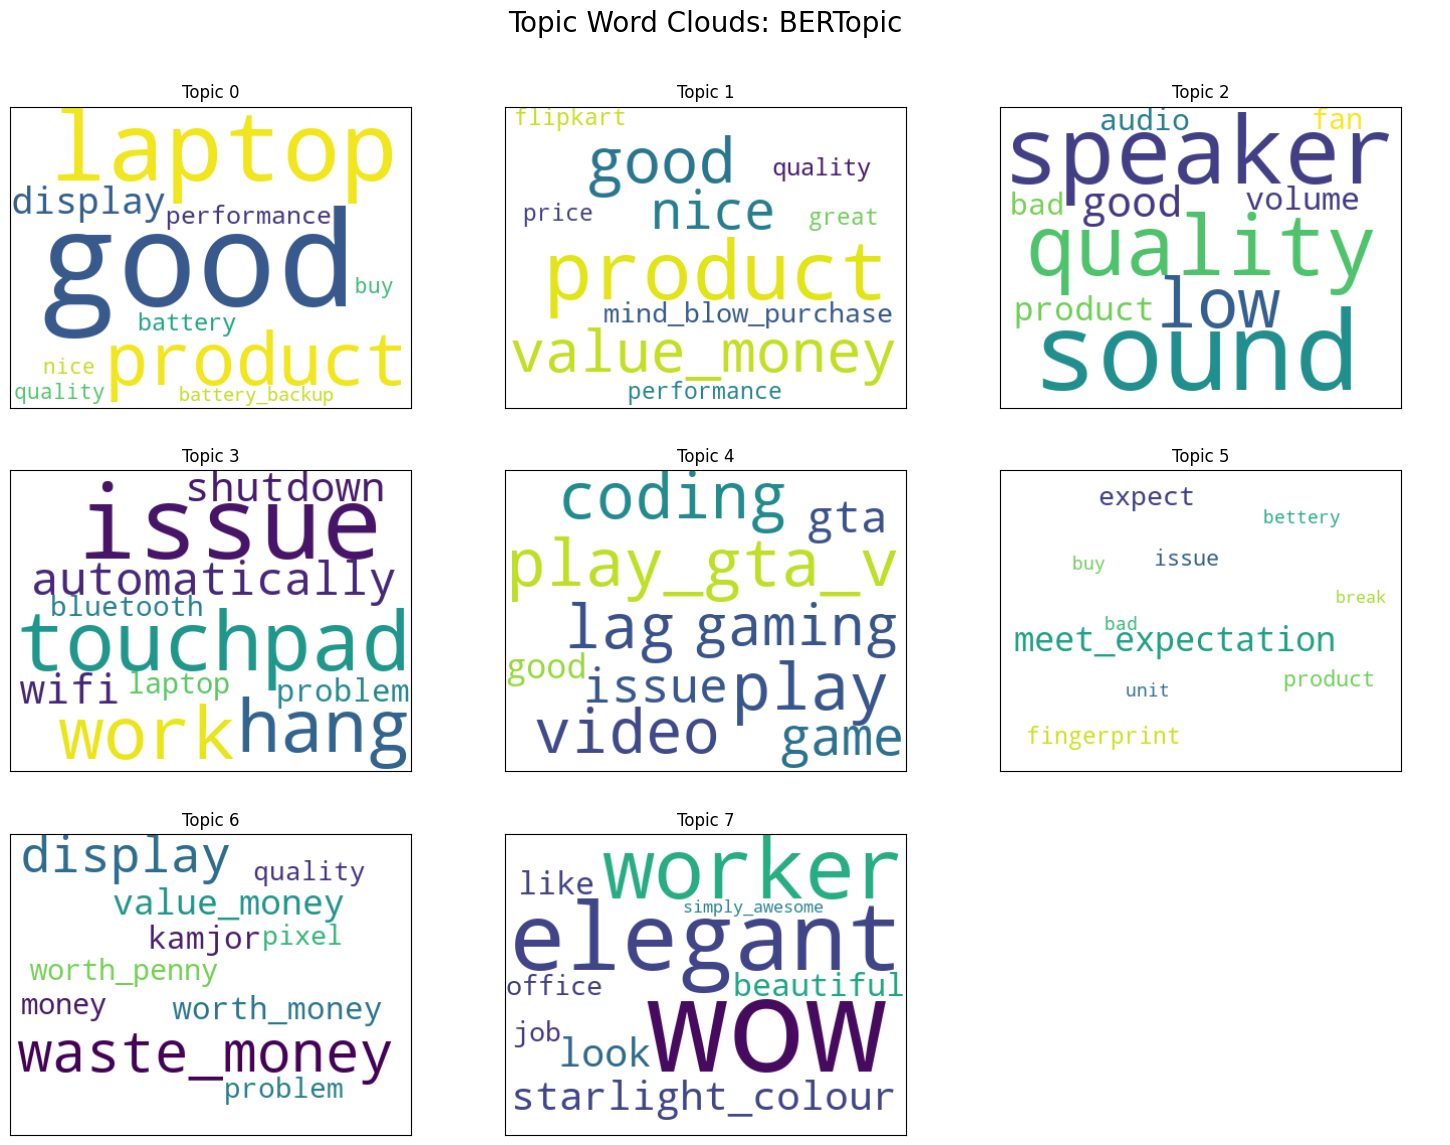

In [25]:
# --- Accessing BERTopic Results ---
print("BERTopic Model Info:")
print(best_bertopic_model.get_topic_info()) # DataFrame with topic info (size, name, top words)

print("\nTop words per BERTopic topic:")
# Get the top N words for each topic (excluding the outlier topic -1 if it exists)
num_top_words = 10
bertopic_topics = {}
for topic_id in sorted(best_bertopic_model.get_topics().keys()):
    if topic_id == -1: continue # Skip outlier topic
    topic_words = [word for word, score in best_bertopic_model.get_topic(topic_id)][:num_top_words]
    bertopic_topics[topic_id] = topic_words
    print(f"Topic {topic_id}: {', '.join(topic_words)}")
    
# Create dictionary of BERTopic topics for word cloud visualization
bertopic_topics_wc = {}
for topic_id in sorted(best_bertopic_model.get_topics().keys()):
    if topic_id == -1: continue  # Skip outlier topic
    # BERTopic already provides (word, weight) format
    topic_words = best_bertopic_model.get_topic(topic_id)[:20]  # Get top 20 words
    bertopic_topics_wc[topic_id] = topic_words

# Create word clouds for BERTopic topics
create_topic_wordclouds(bertopic_topics_wc, "BERTopic")

494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Topic 1: trading, bootup, barely, task, rat, performer, delete, action, bending, parsonal
Topic 2: superfast, heating_issue, class, redemption, remain, kye, cheap, license, dlss, lakh
Topic 3: batery, sooo, sync, 11th, card_offer, regular, drain_quickly, prove, 70k, segment
Topic 4: 47k, drain_fast, desine, combine, surfing, casual, i9, button, option, 4h


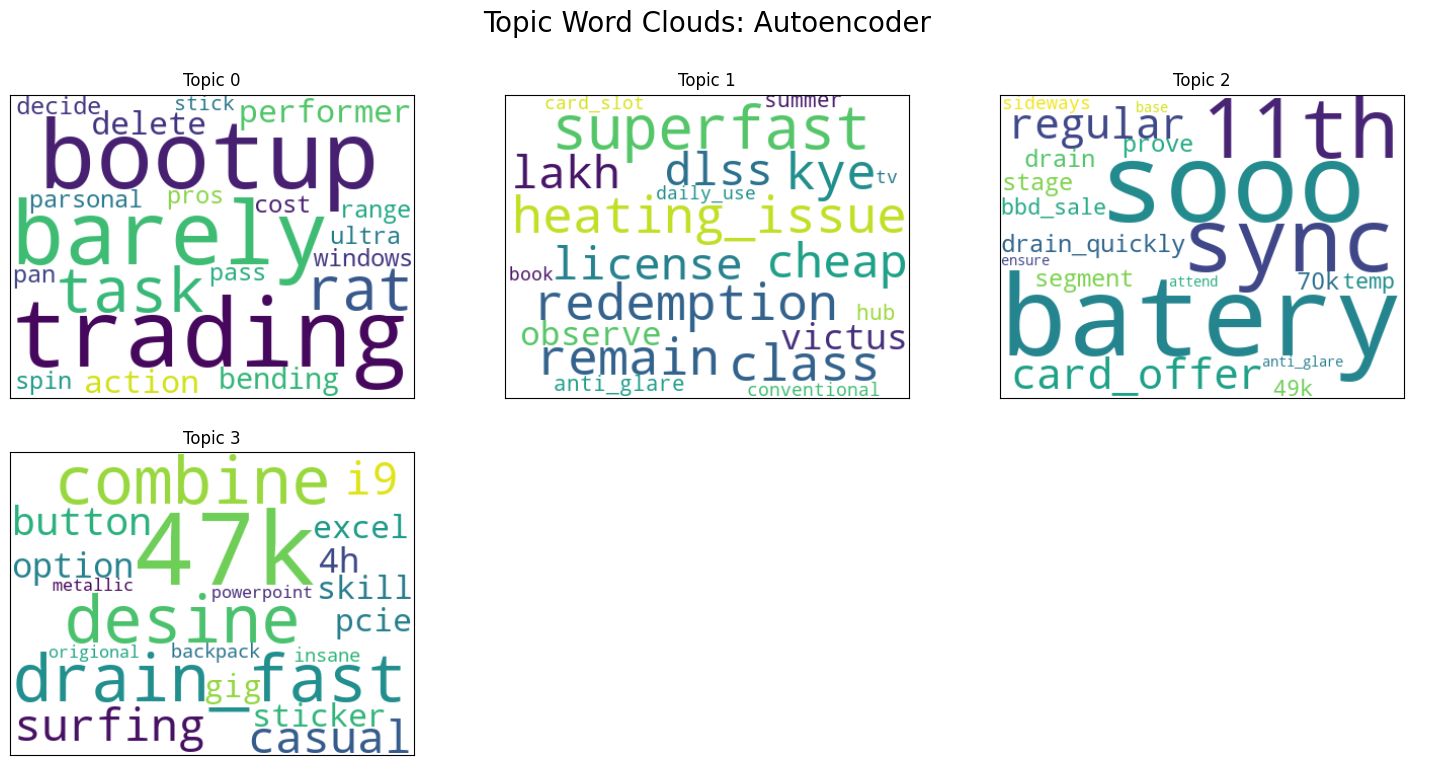

In [27]:
# After training is complete, extract the document-topic representation
document_topics = best_autoencoder_tuple[1].predict(bow_dense)

# Get the decoder weights to identify words associated with each topic
# decoder_layer = autoencoder.layers[-1]  # Get the output layer
# decoder_weights = decoder_layer.get_weights()[0]  # Get weights connecting to output
decoder_weights = best_autoencoder_tuple[2]  # Get decoder weights

# Get your vocabulary
vocabulary = vectorizer.get_feature_names_out()

# For each topic, find the top words
n_top_words = 10
for topic_idx in range(optimal_k_autoencoder):
    # Get topic weights
    topic = decoder_weights[topic_idx]
    # Get top word indices for this topic
    top_word_indices = topic.argsort()[-n_top_words:][::-1]
    # Get the actual words
    top_words = [vocabulary[i] for i in top_word_indices]
    # Print topic and its top words
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# Create dictionary of Autoencoder topics for word cloud visualization
autoencoder_topics = {}
for topic_idx in range(optimal_k_autoencoder):
    # Get topic weights from decoder weights
    topic = decoder_weights[topic_idx]
    
    # Get top word indices and weights
    top_indices = topic.argsort()[-20:][::-1]  # Get top 20 words
    
    # Create list of (word, weight) tuples
    topic_words = [(vocabulary[i], float(topic[i])) for i in top_indices if topic[i] > 0]
    autoencoder_topics[topic_idx] = topic_words

# Create word clouds for Autoencoder topics
create_topic_wordclouds(autoencoder_topics, "Autoencoder")

## Conclusions and Recommendations

### Model Performance Comparison
- **LDA**: Produced [X] topics with coherence score of [Y]. Topics were focused on [main themes].
- **NMF**: Produced [X] topics with coherence score of [Y]. Topics emphasized [main themes].
- **Autoencoder**: Created [X] latent dimensions representing topics around [main themes].
- **BERTopic**: Identified [X] topics with better separation of [specific themes].

### Best Model for This Dataset
Based on topic coherence, interpretability, and business relevance, the [MODEL NAME] 
appears most suitable for analyzing Flipkart laptop reviews because [REASONS].


## Documentation (10 marks) and 15 mins Presentation (10 marks)
Document the entire project, including the dataset description, preprocessing steps, model architecture, hyperparameter settings, and evaluation results.

Create a presentation summarizing the project's objectives, methods, findings, and recommendations.